In [1]:
import pickle
import os
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf, acf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import r2_score
from sklearn import linear_model

%matplotlib inline

In [2]:
intra_filepath = os.getcwd() + r'\Data\Intraday'

#filename_1 = os.path.join(intra_filepath, 'VIX options hamilton.csv')
filename_1 = os.path.join(intra_filepath, 'vixsnaps.csv')
filename_2 = os.path.join(intra_filepath, 'vixsnaps2.csv')

#### Load intraday data from .csv file into pandas dataframe

In [3]:
vix_opt_1 = pd.read_csv(filename_1, parse_dates=['TIMESTAMP'],\
                    date_parser = lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'),\
                    usecols = ['SYMBOL', 'TIMESTAMP', 'MID_VOL', 'DELTA'])

vix_opt_2 = pd.read_csv(filename_2, parse_dates=['TIMESTAMP'],\
                    date_parser = lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'),\
                    usecols = ['SYMBOL', 'TIMESTAMP', 'MID_VOL', 'DELTA'])

#### Screen dataframe and remove options with deltas outside set lo/hi thresholds 

In [4]:
vix_opt_1 = vix_opt_1[(np.abs(vix_opt_1['DELTA']) > 0.15) & (np.abs(vix_opt_1['DELTA']) < 0.85)]
vix_opt_2 = vix_opt_2[(np.abs(vix_opt_2['DELTA']) > 0.15) & (np.abs(vix_opt_2['DELTA']) < 0.85)]

In [5]:
print(vix_opt_1.size, vix_opt_2.size)

1540720 2450388


In [6]:
vix_opt = pd.concat([vix_opt_1, vix_opt_2])
vix_opt.size

3991108

In [7]:
vix_opt.tail()

,SYMBOL,TIMESTAMP,MID_VOL,DELTA
1513755,VIX 170215P00014500,2016-12-30 15:20:00,0.73954,-0.25471
1513756,VIX 170215P00014500,2016-12-30 15:30:00,0.73918,-0.26194
1513757,VIX 170215P00014500,2016-12-30 15:40:00,0.73924,-0.26194
1513758,VIX 170215P00014500,2016-12-30 15:50:00,0.73973,-0.25471
1513759,VIX 170215P00014500,2016-12-30 16:00:00,0.73309,-0.25722


In [3]:
def parse_symbol(x):
    x = x.split()[1]
    date = datetime.strptime(x[:6],'%y%m%d')
    if date.weekday() == 5:
        date -= pd.Timedelta(days=1)
    optiontype = x[6]
    strike = float(x[8:13])/10
    return pd.Series([date, optiontype,strike], index=['exdate', 'cp_flag', 'strike_price'])  

In [9]:
vix_opt[['exdate', 'cp_flag', 'strike_price']] = vix_opt['SYMBOL'].apply(parse_symbol)
vix_opt.head(10)

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price
41,VIX 150121P00015000,2015-01-02 09:40:00,0.98188,-0.23752,2015-01-21,P,15.0
42,VIX 150121P00015000,2015-01-02 09:50:00,0.98063,-0.22941,2015-01-21,P,15.0
43,VIX 150121P00015000,2015-01-02 10:00:00,0.97867,-0.22136,2015-01-21,P,15.0
44,VIX 150121P00015000,2015-01-02 10:10:00,0.97689,-0.19553,2015-01-21,P,15.0
45,VIX 150121P00015000,2015-01-02 10:20:00,0.97708,-0.19553,2015-01-21,P,15.0
46,VIX 150121P00015000,2015-01-02 10:30:00,0.99958,-0.19943,2015-01-21,P,15.0
47,VIX 150121P00015000,2015-01-02 10:40:00,1.03454,-0.15776,2015-01-21,P,15.0
48,VIX 150121P00015000,2015-01-02 10:50:00,1.03089,-0.15844,2015-01-21,P,15.0
49,VIX 150121P00015000,2015-01-02 11:00:00,1.04762,-0.16414,2015-01-21,P,15.0
51,VIX 150121P00015000,2015-01-02 11:20:00,1.06982,-0.15185,2015-01-21,P,15.0


In [10]:
vix_opt.sort_values(by =['TIMESTAMP', 'exdate', 'strike_price', 'cp_flag'], inplace = True)

In [11]:
#vix_opt.tail(10)
vix_opt[vix_opt['TIMESTAMP'] == '2016-12-20 16:00:00']

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price
1505319,VIX 161221C00011000,2016-12-20 16:00:00,1.20724,0.79123,2016-12-21,C,11.0
1506639,VIX 161221P00011000,2016-12-20 16:00:00,1.20651,-0.20879,2016-12-21,P,11.0
1507039,VIX 161221C00011500,2016-12-20 16:00:00,1.40241,0.49865,2016-12-21,C,11.5
1507239,VIX 161221P00011500,2016-12-20 16:00:00,1.28035,-0.50376,2016-12-21,P,11.5
1505359,VIX 161221C00012000,2016-12-20 16:00:00,1.53607,0.26861,2016-12-21,C,12.0
1506679,VIX 161221P00012000,2016-12-20 16:00:00,1.38517,-0.75533,2016-12-21,P,12.0
1507079,VIX 161221C00012500,2016-12-20 16:00:00,1.83214,0.15782,2016-12-21,C,12.5
1492599,VIX 170118C00012500,2016-12-20 16:00:00,0.65487,0.79628,2017-01-18,C,12.5
1492799,VIX 170118P00012500,2016-12-20 16:00:00,0.65391,-0.20282,2017-01-18,P,12.5
1489999,VIX 170118C00013000,2016-12-20 16:00:00,0.69429,0.72324,2017-01-18,C,13.0


In [14]:
#vix_opt.drop_duplicates()
vix_opt.tail()

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price
1512679,VIX 170215P00025000,2016-12-30 16:00:00,1.08136,-0.80193,2017-02-15,P,25.0
1511399,VIX 170215C00026000,2016-12-30 16:00:00,1.09049,0.17317,2017-02-15,C,26.0
1512719,VIX 170215P00026000,2016-12-30 16:00:00,1.11302,-0.81878,2017-02-15,P,26.0
1511439,VIX 170215C00027000,2016-12-30 16:00:00,1.11380,0.15675,2017-02-15,C,27.0
1512759,VIX 170215P00027000,2016-12-30 16:00:00,1.10345,-0.84541,2017-02-15,P,27.0


In [4]:
expiration = pd.read_csv(os.getcwd() + (r'\Data' + '\expiration_dates.csv'), usecols=['vx1'], parse_dates=['vx1'], \
                         date_parser = lambda x: datetime.strptime(x,'%d-%b-%y'))

expiration.head()

,vx1
0,2005-10-19
1,2005-11-16
2,2005-12-21
3,2006-01-18
4,2006-02-15


In [16]:
# Define column numbers for VIX expiration dates in 'expiration_dates.csv'
vx_expirys = 0

def findTerms(date):
    for i in range(expiration.shape[vx_expirys]): # Determine month & year of VIX expiry corresponding to current date
        if expiration.iloc[i,vx_expirys].month == date.month and expiration.iloc[i,vx_expirys].year == date.year:
            break                                 # Effectively reduces search area of posible dates
    
    if date < expiration.iloc[i,vx_expirys]:
        term1 = expiration.iloc[i+0,vx_expirys]
        term2 = expiration.iloc[i+1,vx_expirys]
    else:
        term1 = expiration.iloc[i+1,vx_expirys]
        term2 = expiration.iloc[i+2,vx_expirys]
        
    return pd.Series([term1, term2], index=['Term_1', 'Term_2'])

In [17]:
#vix_opt[(vix_opt['TIMESTAMP'] >= '2015-10-21') & (vix_opt['TIMESTAMP'] < '2015-10-22')]

#### Build test dataframe for relevant VIX options information

In [4]:
vix_test = vix_opt.iloc[:30000].copy()

In [51]:
test_terms = vix_test['TIMESTAMP'].apply(findTerms)

In [52]:
vix_test = pd.concat([vix_test, test_terms], axis=1)

In [5]:
vix_test.tail()

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price,Term_1,Term_2
41067,VIX 150218C00017000,2015-01-22 14:00:00,0.86353,0.66055,2015-02-18,C,17.0,2015-02-18,2015-03-18
39747,VIX 150218P00017000,2015-01-22 14:00:00,0.86339,-0.33932,2015-02-18,P,17.0,2015-02-18,2015-03-18
41107,VIX 150218C00018000,2015-01-22 14:00:00,0.92657,0.57007,2015-02-18,C,18.0,2015-02-18,2015-03-18
39787,VIX 150218P00018000,2015-01-22 14:00:00,0.92655,-0.42980,2015-02-18,P,18.0,2015-02-18,2015-03-18
41147,VIX 150218C00019000,2015-01-22 14:00:00,0.96556,0.48994,2015-02-18,C,19.0,2015-02-18,2015-03-18


#### Apply 'findterms' function to VIX options dataframe, matching trade date with correct front month (VX1) options contract 

In [18]:
#vix_opt['term1'] = vix_opt['TIMESTAMP'].apply(findTerms)
terms = vix_opt['TIMESTAMP'].apply(findTerms)

In [19]:
vix_opt = pd.concat([vix_opt, terms], axis=1)

In [20]:
vix_opt.tail()

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price,Term_1,Term_2
1512679,VIX 170215P00025000,2016-12-30 16:00:00,1.08136,-0.80193,2017-02-15,P,25.0,2017-01-18,2017-02-15
1511399,VIX 170215C00026000,2016-12-30 16:00:00,1.09049,0.17317,2017-02-15,C,26.0,2017-01-18,2017-02-15
1512719,VIX 170215P00026000,2016-12-30 16:00:00,1.11302,-0.81878,2017-02-15,P,26.0,2017-01-18,2017-02-15
1511439,VIX 170215C00027000,2016-12-30 16:00:00,1.11380,0.15675,2017-02-15,C,27.0,2017-01-18,2017-02-15
1512759,VIX 170215P00027000,2016-12-30 16:00:00,1.10345,-0.84541,2017-02-15,P,27.0,2017-01-18,2017-02-15


In [36]:
#type(vix_test['exdate'].iloc[0])

pandas._libs.tslib.Timestamp

In [37]:
#type(vix_test['term1'].iloc[0])

pandas._libs.tslib.Timestamp

In [46]:
test = vix_test[vix_test['exdate'] == vix_test['term1']]

In [47]:
test.tail()

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price,term1
88369,VIX 150218P00025000,2015-01-23 11:00:00,1.23604,-0.79605,2015-02-18,P,25.0,2015-02-18
88489,VIX 150218C00026000,2015-01-23 11:00:00,1.30427,0.18983,2015-02-18,C,26.0,2015-02-18
88529,VIX 150218P00026000,2015-01-23 11:00:00,1.24464,-0.82568,2015-02-18,P,26.0,2015-02-18
88649,VIX 150218C00027000,2015-01-23 11:00:00,1.32447,0.16700,2015-02-18,C,27.0,2015-02-18
88689,VIX 150218P00027000,2015-01-23 11:00:00,1.32457,-0.83298,2015-02-18,P,27.0,2015-02-18


#### Save/Retrieve vix_opt dataframe to/from pickle file

In [21]:
#vix_opt.to_pickle(intra_filepath + r'\Pickle\vix_opt.pkl')
vix_opt.to_pickle(intra_filepath + r'\Pickle\vix_opt_2term.pkl')

In [2]:
#vix_opt = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vix_opt.pkl', "rb"))
vix_opt = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vix_opt_2term.pkl', "rb"))

#### Check for duplicate rows

In [6]:
vix_opt[vix_opt.duplicated()].size

0

In [7]:
vix_opt.size

8979993

#### Calculate individual trade dates from TIMESTAMP

In [8]:
trade_dates = pd.DataFrame(np.unique(vix_opt['TIMESTAMP'].apply(lambda x: x.strftime('%Y-%m-%d'))))

In [9]:
trade_dates.head()

,0
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08


In [10]:
len(trade_dates)

496

In [11]:
trade_dates = np.array([pd.Timestamp(x) for x in np.unique(trade_dates)])

#### Add additional trade dates to dataset

In [12]:
extra_dates = pd.date_range('2014-12-16', '2014-12-31', freq=pd.tseries.offsets.BDay()).tolist()

#### Remove Christmas as a trade date

In [13]:
extra_dates.pop(7)

Timestamp('2014-12-25 00:00:00', freq='B')

In [14]:
extra_dates

[Timestamp('2014-12-16 00:00:00', freq='B'),
 Timestamp('2014-12-17 00:00:00', freq='B'),
 Timestamp('2014-12-18 00:00:00', freq='B'),
 Timestamp('2014-12-19 00:00:00', freq='B'),
 Timestamp('2014-12-22 00:00:00', freq='B'),
 Timestamp('2014-12-23 00:00:00', freq='B'),
 Timestamp('2014-12-24 00:00:00', freq='B'),
 Timestamp('2014-12-26 00:00:00', freq='B'),
 Timestamp('2014-12-29 00:00:00', freq='B'),
 Timestamp('2014-12-30 00:00:00', freq='B'),
 Timestamp('2014-12-31 00:00:00', freq='B')]

In [15]:
extra_dates_2 = pd.date_range('2017-01-01', '2017-01-20', freq=pd.tseries.offsets.BDay()).tolist()

#### Remove MLK Holiday as a trade date

In [16]:
extra_dates_2.pop(10)

Timestamp('2017-01-16 00:00:00', freq='B')

In [17]:
extra_dates_2

[Timestamp('2017-01-02 00:00:00', freq='B'),
 Timestamp('2017-01-03 00:00:00', freq='B'),
 Timestamp('2017-01-04 00:00:00', freq='B'),
 Timestamp('2017-01-05 00:00:00', freq='B'),
 Timestamp('2017-01-06 00:00:00', freq='B'),
 Timestamp('2017-01-09 00:00:00', freq='B'),
 Timestamp('2017-01-10 00:00:00', freq='B'),
 Timestamp('2017-01-11 00:00:00', freq='B'),
 Timestamp('2017-01-12 00:00:00', freq='B'),
 Timestamp('2017-01-13 00:00:00', freq='B'),
 Timestamp('2017-01-17 00:00:00', freq='B'),
 Timestamp('2017-01-18 00:00:00', freq='B'),
 Timestamp('2017-01-19 00:00:00', freq='B'),
 Timestamp('2017-01-20 00:00:00', freq='B')]

#### Combine and sort additional trade dates

In [18]:
trade_dates = np.append(trade_dates, extra_dates)

In [19]:
trade_dates = np.append(trade_dates, extra_dates_2)

In [20]:
trade_dates.sort()

In [21]:
trade_dates[-20:]

array([Timestamp('2016-12-22 00:00:00'), Timestamp('2016-12-23 00:00:00'),
       Timestamp('2016-12-27 00:00:00'), Timestamp('2016-12-28 00:00:00'),
       Timestamp('2016-12-29 00:00:00'), Timestamp('2016-12-30 00:00:00'),
       Timestamp('2017-01-02 00:00:00', freq='B'),
       Timestamp('2017-01-03 00:00:00', freq='B'),
       Timestamp('2017-01-04 00:00:00', freq='B'),
       Timestamp('2017-01-05 00:00:00', freq='B'),
       Timestamp('2017-01-06 00:00:00', freq='B'),
       Timestamp('2017-01-09 00:00:00', freq='B'),
       Timestamp('2017-01-10 00:00:00', freq='B'),
       Timestamp('2017-01-11 00:00:00', freq='B'),
       Timestamp('2017-01-12 00:00:00', freq='B'),
       Timestamp('2017-01-13 00:00:00', freq='B'),
       Timestamp('2017-01-17 00:00:00', freq='B'),
       Timestamp('2017-01-18 00:00:00', freq='B'),
       Timestamp('2017-01-19 00:00:00', freq='B'),
       Timestamp('2017-01-20 00:00:00', freq='B')], dtype=object)

In [22]:
vix_opt['Term_1'].iloc[0]

Timestamp('2015-01-21 00:00:00')

In [27]:
def findOptions(df):
    prev_term = expiration[expiration['vx1'] == df['Term_1'].iloc[0]].index[0] - 1
    term1 = df[df['exdate'] == df['Term_1'].iloc[0]]
    term2 = df[df['exdate'] == df['Term_2'].iloc[0]]
    #t1 = len(trade_dates[(trade_dates > df['TIMESTAMP'].iloc[0]) & ( trade_dates <= df['Term_1'].iloc[0] )])
    ##t2 = len(trade_dates[(trade_dates > df['TIMESTAMP'].iloc[0]) & ( trade_dates <= df['Term_2'].iloc[0] )])
    
    # Calculate number of total trading dates between previous & current VIX expiration dates
    tdates_per_expiry = len(trade_dates[(trade_dates >= expiration.iloc[prev_term]['vx1'])\
                                         & ( trade_dates < df['Term_1'].iloc[0] )])
    
    # Calculate current timestamp & future VIX expirys out to the hour & minute 
    # This approach allows for a more continuous view of Time to Expiry (TTE)
    partial_day = (df['TIMESTAMP'].iloc[0].hour + df['TIMESTAMP'].iloc[0].minute/60)/24 - 9.5/24
    t1 = len(trade_dates[(trade_dates > df['TIMESTAMP'].iloc[0]) & ( trade_dates <= df['Term_1'].iloc[0] )]) - partial_day
    #t2 = len(trade_dates[(trade_dates >= expiration.iloc[prev_term]['vx1']) & (trade_dates < df['Term_1'].iloc[0])]) - partial_day
    
    if term1.shape[0] == 0 or term2.shape[0] == 0:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, t1, t2], index=['Strike1','Strike2','Option1','Option2','t1','t2'])
        
    #print(df['date'].iloc[0])
    strike_list1 = np.unique(term1['strike_price'])
    #print(strike_list1)
    mindelta1 = 5
    for strikeIndx, strike in enumerate(strike_list1): 
        x = np.abs(term1[term1['strike_price'] == strike]['DELTA'].sum())
        if x < mindelta1:
            mindelta1 = x
            minStrike1 = strike
            
    strike_list2 = np.unique(term2['strike_price'])
    mindelta2 = 5
    for strikeIndx, strike in enumerate(strike_list2): 
        x = np.abs(term2[term2['strike_price'] == strike]['DELTA'].sum())
        if x < mindelta2:
            mindelta2 = x
            minStrike2 = strike
            
    avg1 = term1[term1['strike_price'] == minStrike1]['MID_VOL'].mean()
    avg2 = term2[term2['strike_price'] == minStrike2]['MID_VOL'].mean()
    
    return pd.Series([minStrike1, minStrike2, avg1, avg2, t1, tdates_per_expiry],\
                     index=['Strike1', 'Strike2','Option1', 'Option2','t1','trade_dates/expiry']) 

In [27]:
if 0:
    def findOptions(df):
        term1 = df[df['exdate'] == df['Term_1'].iloc[0]]
        term2 = df[df['exdate'] == df['Term_2'].iloc[0]]
        t1 = len(trade_dates[(trade_dates > df['TIMESTAMP'].iloc[0]) & ( trade_dates <= df['Term_1'].iloc[0] )])
        t2 = len(trade_dates[(trade_dates > df['TIMESTAMP'].iloc[0]) & ( trade_dates <= df['Term_2'].iloc[0] )])

        if term1.shape[0] == 0 or term2.shape[0] == 0:
            return pd.Series([np.nan, np.nan, np.nan, np.nan, t1, t2], index=['Strike1','Strike2','Option1','Option2','t1','t2'])

        #print(df['date'].iloc[0])
        strike_list1 = np.unique(term1['strike_price'])
        #print(strike_list1)
        mindelta1 = 5
        for strikeIndx, strike in enumerate(strike_list1): 
            x = np.abs(term1[term1['strike_price'] == strike]['DELTA'].sum())
            if x < mindelta1:
                mindelta1 = x
                minStrike1 = strike

        strike_list2 = np.unique(term2['strike_price'])
        mindelta2 = 5
        for strikeIndx, strike in enumerate(strike_list2): 
            x = np.abs(term2[term2['strike_price'] == strike]['DELTA'].sum())
            if x < mindelta2:
                mindelta2 = x
                minStrike2 = strike

        avg1 = term1[term1['strike_price'] == minStrike1]['MID_VOL'].mean()
        avg2 = term2[term2['strike_price'] == minStrike2]['MID_VOL'].mean()

        return pd.Series([minStrike1, minStrike2, avg1, avg2, t1, t2], index=['Strike1', 'Strike2','Option1', 'Option2','t1','t2']) 

In [28]:
vix_opt.iloc[:1000,:].groupby('TIMESTAMP').apply(findOptions)

,Strike1,Strike2,Option1,Option2,t1,trade_dates/expiry
TIMESTAMP,,,,,,
2015-01-02 09:40:00,18.0,19.0,1.228430,1.043855,11.993056,22.0
2015-01-02 09:50:00,18.0,19.0,1.221115,1.044015,11.986111,22.0
2015-01-02 10:00:00,18.0,19.0,1.221235,1.048970,11.979167,22.0
2015-01-02 10:10:00,19.0,19.0,1.301530,1.043025,11.972222,22.0
2015-01-02 10:20:00,19.0,19.0,1.301785,1.042710,11.965278,22.0
2015-01-02 10:30:00,19.0,19.0,1.309800,1.043180,11.958333,22.0
2015-01-02 10:40:00,19.0,20.0,1.349270,1.102330,11.951389,22.0
2015-01-02 10:50:00,19.0,20.0,1.357470,1.107395,11.944444,22.0
2015-01-02 11:00:00,19.0,20.0,1.358435,1.102755,11.937500,22.0


#### Apply 'findOptions' function to vix_opt dataframe to determine correct ATM implied vol of VIX options for each timestamp

In [29]:
# TEST dataframe
#vix_vol = vix_test.groupby('TIMESTAMP').apply(findOptions)

# ENTIRE dataframe
vix_vol = vix_opt.groupby('TIMESTAMP').apply(findOptions)

In [68]:
vix_vol.head()

,Strike1,Strike2,Option1,Option2,t1,trade_dates/expiry
TIMESTAMP,,,,,,
2015-01-02 09:40:00,18.0,19.0,1.228430,1.043855,11.993056,22.0
2015-01-02 09:50:00,18.0,19.0,1.221115,1.044015,11.986111,22.0
2015-01-02 10:00:00,18.0,19.0,1.221235,1.048970,11.979167,22.0
2015-01-02 10:10:00,19.0,19.0,1.301530,1.043025,11.972222,22.0
2015-01-02 10:20:00,19.0,19.0,1.301785,1.042710,11.965278,22.0


#### Calculate Time-Weighted average of implied vol between 1st & 2nd VIX options contracts

In [69]:
vix_vol['Weight_Opt'] = (vix_vol['Option1']*(vix_vol['t1']/vix_vol['trade_dates/expiry'])) + \
                        (vix_vol['Option2']*(1-(vix_vol['t1']/vix_vol['trade_dates/expiry'])))

In [70]:
vix_vol.head()

,Strike1,Strike2,Option1,Option2,t1,trade_dates/expiry,Weight_Opt
TIMESTAMP,,,,,,,
2015-01-02 09:40:00,18.0,19.0,1.228430,1.043855,11.993056,22.0,1.144474
2015-01-02 09:50:00,18.0,19.0,1.221115,1.044015,11.986111,22.0,1.140503
2015-01-02 10:00:00,18.0,19.0,1.221235,1.048970,11.979167,22.0,1.142770
2015-01-02 10:10:00,19.0,19.0,1.301530,1.043025,11.972222,22.0,1.183701
2015-01-02 10:20:00,19.0,19.0,1.301785,1.042710,11.965278,22.0,1.183615


#### Save/Retrieve vix_vol dataframe to/from pickle file 

In [71]:
#vix_vol.to_pickle(intra_filepath + r'\Pickle\vix_vol.pkl')
vix_vol.to_pickle(intra_filepath + r'\Pickle\vix_vol_2terms.pkl')

In [3]:
#vix_vol = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vix_vol.pkl', "rb"))

In [40]:
#vix_vol.head(20)
vix_vol[vix_vol.index=='2015-01-02 09:40:00']

,Strike1,Strike2,Option1,Option2,t1,t2,Weight_Opt
TIMESTAMP,,,,,,,
2015-01-02 09:40:00,18.0,19.0,1.22843,1.043855,12.0,22.0,1.144532


In [37]:
max(vix_vol['t1'])

25.0

In [31]:
vix_vol[vix_vol['Strike1'].isna()].shape

(0, 4)

In [30]:
vix_vol.shape

(19344, 4)

#### Load VIX futures time series data for modeling

In [22]:
vx1_opt = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vx1_opt.pkl', "rb"))

In [23]:
vx1 = vx1_opt['Mid']
vx1_diff = vx1.diff().dropna().rename('vx1_diff').to_frame()

In [24]:
vix_vol_diff = vix_vol['Option1'].diff().dropna().rename('vol_diff').to_frame()
mydata = vx1_diff.merge(vix_vol_diff, how='inner', left_index=True, right_index=True)
mydata.head()

,vx1_diff,vol_diff
2015-01-02 09:50:00,0.10,-0.007315
2015-01-02 10:00:00,0.10,0.000120
2015-01-02 10:10:00,0.35,0.080295
2015-01-02 10:20:00,0.00,0.000255
2015-01-02 10:30:00,0.00,0.008015


In [25]:
mydata['shift1'] = mydata['vol_diff'].shift(1)
mydata['shift2'] = mydata['vol_diff'].shift(2)
mydata['shift3'] = mydata['vol_diff'].shift(3)
mydata['shift4'] = mydata['vol_diff'].shift(4)
mydata['shift5'] = mydata['vol_diff'].shift(5)
mydata.dropna(inplace=True)
mydata.head()

,vx1_diff,vol_diff,shift1,shift2,shift3,shift4,shift5
2015-01-02 10:40:00,0.75,0.039470,0.008015,0.000255,0.080295,0.000120,-0.007315
2015-01-02 10:50:00,0.00,0.008200,0.039470,0.008015,0.000255,0.080295,0.000120
2015-01-02 11:00:00,-0.05,0.000965,0.008200,0.039470,0.008015,0.000255,0.080295
2015-01-02 11:10:00,0.20,0.074540,0.000965,0.008200,0.039470,0.008015,0.000255
2015-01-02 11:20:00,0.10,0.023430,0.074540,0.000965,0.008200,0.039470,0.008015


In [26]:
y = mydata.iloc[:,0].values
x = mydata.iloc[:,2:].values

In [27]:
lr = linear_model.LinearRegression()
lr.fit(x,y)
lr.score(x,y)

0.00070337673005549384

In [11]:
vx1_diff_plot = mydata['vx1_diff'].to_frame()

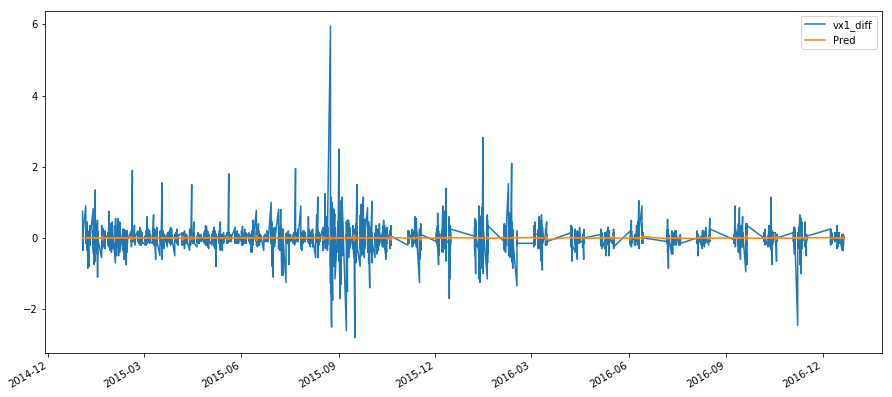

In [12]:
vx1_diff_plot['Pred'] = lr.predict(x)

# Plot Actual vs. Predicted
vx1_diff_plot.plot(figsize=(15,7))

### Generate 2015-2016 dataset request (for VIX Options)

In [3]:
vix_opt.tail()

,SYMBOL,TIMESTAMP,MID_VOL,DELTA,exdate,cp_flag,strike_price,Term_1,Term_2
1512679,VIX 170215P00025000,2016-12-30 16:00:00,1.08136,-0.80193,2017-02-15,P,25.0,2017-01-18,2017-02-15
1511399,VIX 170215C00026000,2016-12-30 16:00:00,1.09049,0.17317,2017-02-15,C,26.0,2017-01-18,2017-02-15
1512719,VIX 170215P00026000,2016-12-30 16:00:00,1.11302,-0.81878,2017-02-15,P,26.0,2017-01-18,2017-02-15
1511439,VIX 170215C00027000,2016-12-30 16:00:00,1.11380,0.15675,2017-02-15,C,27.0,2017-01-18,2017-02-15
1512759,VIX 170215P00027000,2016-12-30 16:00:00,1.10345,-0.84541,2017-02-15,P,27.0,2017-01-18,2017-02-15


In [4]:
vix_opt_d = vix_opt.drop_duplicates(subset=['TIMESTAMP'])
vix_opt_req = vix_opt_d[['TIMESTAMP', 'Term_1', 'Term_2']]

In [5]:
vix_opt_req['Date'] = vix_opt_req['TIMESTAMP'].apply(lambda x: x.date())

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
def last_two_timestamp(df):
    output = df.iloc[-2:,:].copy()
    output['TIMESTAMP'].iloc[0] += pd.Timedelta(minutes=20) 
    output['TIMESTAMP'].iloc[1] += pd.Timedelta(minutes=15) 
    return output

In [18]:
df = vix_opt_req.groupby('Date').apply(last_two_timestamp)

#vix_opt_req.groupby('Date').apply(last_two_timestamp)

In [19]:
df.head()

TIMESTAMP     Term_1     Term_2        Date
Date                                                                 
2015-01-02 2998 2015-01-02 16:10:00 2015-01-21 2015-02-18  2015-01-02
           2999 2015-01-02 16:15:00 2015-01-21 2015-02-18  2015-01-02
2015-01-05 4478 2015-01-05 16:10:00 2015-01-21 2015-02-18  2015-01-05
           4479 2015-01-05 16:15:00 2015-01-21 2015-02-18  2015-01-05
2015-01-06 7518 2015-01-06 16:10:00 2015-01-21 2015-02-18  2015-01-06

In [20]:
df = df[['TIMESTAMP','Term_1','Term_2']]

In [22]:
print(df.shape)
df.head()

(992, 3)


TIMESTAMP     Term_1     Term_2
Date                                                     
2015-01-02 2998 2015-01-02 16:10:00 2015-01-21 2015-02-18
           2999 2015-01-02 16:15:00 2015-01-21 2015-02-18
2015-01-05 4478 2015-01-05 16:10:00 2015-01-21 2015-02-18
           4479 2015-01-05 16:15:00 2015-01-21 2015-02-18
2015-01-06 7518 2015-01-06 16:10:00 2015-01-21 2015-02-18

In [12]:
#df[['TIMESTAMP','Term_1','Term_2']].head()

#df = vix_opt_req[['TIMESTAMP','Term_1','Term_2']]

#### Export VIX Options data request to .csv file

In [23]:
df.to_csv(os.getcwd() + r'\Data\Hamilton_dataset_request(VIX futures & options.2015-2016.csv', index=False)